# Projeto Padrões de Projeto

# Treinamento da Rede

Esta implementação tem como objetivo criar o treinamento da rede com curriculos os dados oriundos do lattes para classificação de demandas.

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
import multiprocessing
from sklearn import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tqdm import tqdm
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
import joblib

In [26]:
pd.set_option('display.max_columns', 131)
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_colwidth', -1)
tqdm.pandas(desc="progress-bar")

C:\Users\jhassam\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Indice:
* [1. Carga dos Dados](#first-bullet)
* [2. Tratamento dos Dados](#second-bullet)
* [3. Criação do Modelo](#4th-bullet)
* [4. Matriz de Confusão](#5th-bullet)


## 1. Carga dos dados <a class="anchor" id="first-bullet"></a>
As informações utilizadas para treinamento o  serão carregadas do arquivo dados_treino.csv ,arquivo criado com base nos dados oriundos do lattes

In [27]:
df = pd.read_csv("dados_treino.csv",sep=';')

In [28]:
df.head(100)

,Descricao,Class
0,possui graduacao em ciencias sociais pela universidade do vale do paraiba possui especializacao em gestao estrategica da inovacao tecnologica pela unicamp atualmente e professor de inovacao e empreendedorismo da fatec sao jose dos campos tem experiencia na area de gestao de projetos de inovacao atuando principalmente nos seguintes temas inovacao tecnologica gestao de projetos parques tecnologicos incubadoras modelagem de negocios e captacao de recursos publicos e privados ciencias sociais,0
1,possui graduacao em direito pela faculdade de direito de taubate graduacao em letras pela faculdade de filosofia ciencias e letras de taubate graduacao em pedagogia pela faculdade de educacao de guaratingueta mestrado em direito pela pontificia universidade catolica de sao paulo e doutorado em direito pela pontificia universidade catolica de sao paulo atualmente e professora de direito e comunicacao e expressao da faculdade de tecnologia de sao jose dos campos direito letras pedagogia direito law direito law,0
2,mestre em engenharia eletronica e computacao instituo tecnologico de aeronautica engenheiro de infraestrutura aeronautica instituto tecnologico de aeronautica professor da faculdade de tecnologia de sao jose dos campos das disciplinas arquitetura e organizacao de computadores fundamentos de redes de computadores tecnologia e ambiente e meio ambiente e saude professor da disciplina ciencias ambientais e das aguas da faculdade de tecnologia de jacarei socio diretor das empresas micro assist infomatica ltda e actie ltda com sede em sao jose dos campos experiencia na area de informatica redes de computadores microcomputadores cabeamento estruturado de redes fibras oticas etc engenharia civil engenharia mecanica transmissao e conservacao de energia educacao em energia e meio ambiente ex diretor da fatec guaratingueta ex diretor da fatec sao jose dos campos e ex coordenador dos cursos de estruturas leves automacao aeronautica e projetos de estruturas aeronauticas da fatec sao jose dos campos engenharia de infreestrutura aeronautica estudo comparativo tecnico e economico entre metodos de dimensionamento de pavimentos aeroportuarios formacao de oficiais aviadores engenharia eletronica e computacao um sistema computadorizado de baixo custo para treinar controladores em radar de aproximacao de precisao sipar electric engineering controle de trafego aereo engenharia mecanica mechanical engineering,0
3,possui graduacao em fisica pela universidade de sao paulo mestrado em sensoriamento remoto pelo instituto nacional de pesquisas espaciais e doutorado em computacao aplicada pelo instituto nacional de pesquisas espaciais tem experiencia na area de computacao com enfase em otimizacao combinatoria atuando principalmente nos seguintes temas problemas de localizacao problema das pmedianas capacitado problema de roteamento de veiculos tendo interesse tambem por programacao orientada a objetos e algoritmos atualmente professor categoria iiid e coordenador do curso de tecnologia em analise e desenvolvimento de sistema da fatec de sao jose dos campos fisica sensoriamento remoto simulacao do coeficiente de retroespalhamento de radar na banda c para solos nus tipicos do estado de sao paulo geosciences retroespalhamento radar computacao aplicada heuristica de localizacaoalocacao para problemas de localizacao de facilidades computer science,0
4,possui graduacao em ciencia da computacao pelo centro universitario do triangulo mestrado e doutorado em computacao aplicada pelo inpe instituto nacional de pesquisas espaciais atuou em projetos de armazenamento e disseminacao de dados ambientais no inpe atualmente e professor da etep faculdades centro universitario eniac faculdade inpg de sao jose dos campos e fatec de jacarei e sao jose dos campos possui experiencia na area de ciencia da computacao com enfase em banco de dados e desenvolvimento de sistemas web ciencia da computacao computacao aplicada esqueletos isotropicos computer science morfo

## 2. Tratamento dos Dados <a class="anchor" id="second-bullet"></a>

In [29]:
df['Descricao'].apply(lambda x: len(x.split(' '))).sum()

15472

In [30]:
train, test = train_test_split(df, test_size=0.1, random_state=42)
#nltk.download()
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 3:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Descricao']), tags=[r.Class]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Descricao']), tags=[r.Class]), axis=1)

In [31]:
test['Class'].value_counts()

1    5
2    3
0    3
Name: Class, dtype: int64

In [32]:
cores = multiprocessing.cpu_count()

## 3. Criação do Modelo <a class="anchor" id="4th-bullet"></a>

In [33]:
model_dbow = Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores, alpha=0.025, min_alpha=0.001)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

train_tagged  = utils.shuffle(train_tagged)
model_dbow.train(train_tagged,total_examples=len(train_tagged), epochs=30)
def vector_for_learning(model, input_docs):
    sents = input_docs
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, feature_vectors

100%|██████████| 92/92 [00:00<00:00, 92359.02it/s]


In [34]:
y_train, X_train = vector_for_learning(model_dbow, train_tagged)
y_test, X_test = vector_for_learning(model_dbow, test_tagged)

In [35]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Users\jhassam\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jhassam\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.36363636363636365
Testing F1 score: 0.341991341991342


## Paragraph to Vector

## Bag of Words

In [36]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 92/92 [00:00<?, ?it/s]


In [37]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 92/92 [00:00<?, ?it/s]


Wall time: 786 ms


In [38]:
y_train, X_train = vector_for_learning(model_dmm, train_tagged)
y_test, X_test = vector_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Users\jhassam\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jhassam\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.2727272727272727
Testing F1 score: 0.22272727272727275


In [39]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [40]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [41]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [42]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Users\jhassam\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jhassam\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.2727272727272727


C:\Users\jhassam\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing F1 score: 0.12587412587412586


In [43]:
filename = 'word2vec.h5'
joblib.dump(logreg, filename)

['word2vec.h5']

## 4. Matriz de Confusão <a class="anchor" id="5th-bullet"></a>

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[0 0 3]
 [1 0 4]
 [0 0 3]]


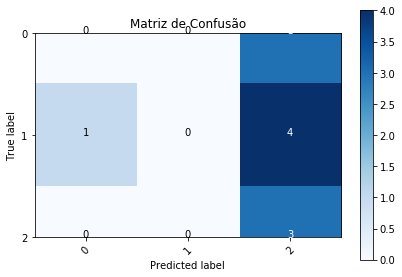

In [45]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2],
                      title='Matriz de Confusão')